In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from datetime import datetime
import pandas as pd

#this is clean version of code developed in weather_data_pandas.ipynb file

In [50]:
#Import Grayling TDR data through XX date

log_df = pd.read_excel('Optn2_Precip+TDR at Grayling.xlsx', sheet_name=1, 
                       index_col=0, parse_dates=True) 
    #alternate: log_df['Name of column with dates in it'] = pd.to_datetime(log_df['Name of column with dates in it'])
    #log_df = log_df.set_index('datetime')          

log_df.index

DatetimeIndex(['2025-06-19 14:45:00', '2025-06-19 15:00:00',
               '2025-06-19 15:15:00', '2025-06-19 15:30:00',
               '2025-06-19 15:45:00', '2025-06-19 16:00:00',
               '2025-06-19 16:15:00', '2025-06-19 16:30:00',
               '2025-06-19 16:45:00', '2025-06-19 17:00:00',
               ...
               '2025-09-22 08:55:00', '2025-09-22 09:00:00',
               '2025-09-22 09:05:00', '2025-09-22 09:10:00',
               '2025-09-22 09:15:00', '2025-09-22 09:20:00',
               '2025-09-22 09:25:00', '2025-09-22 09:30:00',
               '2025-09-22 09:35:00', '2025-09-22 09:40:00'],
              dtype='datetime64[ns]', name='DateTime', length=25582, freq=None)

In [171]:
# New 10/16/25 process GAAF weather station data downloaded separately from TDR file

rain_df = pd.read_csv('data/GAAF Precipication March-Oct 2025.csv') #import raw data with no changes
rain_df['date/time'] = pd.to_datetime(rain_df['date/time'], format='%m/%d/%Y %H:%M') #explicitly turn to datetime in the correct format, above used parse_dates=True to do this automatically
rain_df.set_index('date/time', inplace=True) #set datetime column as index
    
print(rain_df.columns)
print(rain_df.dtypes)

# Turn values to numerical for sum using dtype conversion
rain_df["p01m"] = (rain_df["p01m"]
    .replace("T", 0)     # remove T for trace
    .replace("NA", np.nan)   # missing values → NaN
    .astype(float)) # to cast as float data type

print(rain_df.dtypes)

# Resample hourly rainfall to daily totals
daily_rain_df = rain_df.resample("D").sum() #daily cumulative precip
daily_rain_df = daily_rain_df.rename(columns={"p01m": "Daily Precip (mm)"}) #rename the column
daily_rain_df.index.name = 'Date' #rename the index column
daily_rain_df.to_csv("GAAF_daily_precip_03.01-10.15.2025.csv")

daily_rain_df.head()
#next update plot, name of df is same as previous so new precip can automatically override the old

Index(['p01m'], dtype='object')
p01m    object
dtype: object
p01m    float64
dtype: object


,Daily Precip (mm)
Date,
2025-03-01,0.51
2025-03-02,0.00
2025-03-03,0.00
2025-03-04,0.25
2025-03-05,25.90


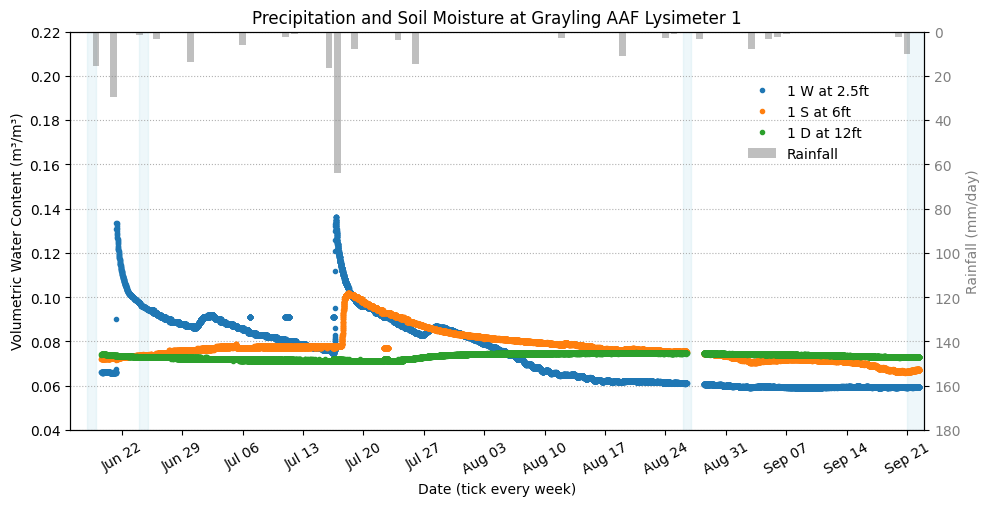

In [52]:
# Grayling soil moisture and precipitation plot

# First set figure size/prepare canvas 
    #yes this needs to be at the beginning
    #syntax: fig, ax = plt.subplots(figsize=(width, height)) where units is inches
fig, ax1 = plt.subplots(figsize=(10,5))

# First y-axis: volumetric water content plotted as dots (similar to scatter plot)
ax1.plot(log_df.index, log_df['01 W at 2.5 ft m³/m³ Water Content'], label="1 W at 2.5ft", linestyle='', marker='.') 
    #purpose of index command is plot the index column (here datetime) on x-axis
    #alternative is reference another column as x-axis, for expl log_df['Date']
ax1.plot(log_df.index, log_df['01 S at 6 ft m³/m³ Water Content'], label="1 S at 6ft", linestyle='', marker='.')
ax1.plot(log_df.index, log_df['01 D at 12 ft m³/m³ Water Content'], label="1 D at 12ft", linestyle='', marker='.')
ax1.set_ylabel("Volumetric Water Content (m³/m³)") #, color="blue")
ax1.set_ylim(0.04, 0.22) 
ax1.tick_params(axis="y") #, labelcolor="blue")
ax1.grid(axis='y', linestyle=':') # add dotted horizontal grid lines for moisture

# Customize x-axis ticks
start_date = datetime(2025, 6, 16) #this was first day of drilling, TDR not yet installed or connected
end_date = datetime(2025, 9, 23)
ax1.set_xlim(start_date, end_date)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7)) #sets ticks every 7 days
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) #formats labels as month day
#alternatives
    #ax1.set_xlim(2025, 6, 15, 2025, 9, 30) #this also works for setting date range and is just one line
    #ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2)) #sets ticks every 2 weeks on Mondays
    #ax1.xaxis.set_major_locator(mdates.MonthLocator())  # set major ticks every month
    #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as 'Jun 2025'
    #ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1)) #add minor ticks every 1 day
    #ax1.tick_params(axis='x', which='minor', length=2)  #shorten minor ticks
ax1.tick_params(axis='x', rotation=30)
ax1.set_xlabel("Date (tick every week)") #adds an axis label

# Second y-axis: rainfall plotted as bars
ax2 = ax1.twinx()
ax2.bar(daily_rain_df.index, daily_rain_df['Daily Precip (mm)'], color="gray", alpha=0.5, label="Rainfall")
ax2.invert_yaxis()  #reverse y-axis so bars come from top
ax2.set_ylabel("Rainfall (mm/day)", color="gray")
ax2.set_ylim(180, 0) #adjust to match dotted lines, 9 steps just like left y-axis
ax2.tick_params(axis="y", labelcolor="gray")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.95, 0.9), frameon=False) #loc='upper right'

# Highlight a specific date range with semi-transparent colored bars
highlight_ranges = [ #populate with list of date ranges aka tuples
    #days samples were collected from the lysimeters, should adjust for dates the vacc was set
    (datetime(2025, 6, 18), datetime(2025, 6, 19)), 
    (datetime(2025, 6, 24), datetime(2025, 6, 25)),
    (datetime(2025, 8, 26), datetime(2025, 8, 27)),
    (datetime(2025, 9, 21), datetime(2025, 9, 24))] #when sampling event is over confirm dates
for start, end in highlight_ranges:
    ax1.axvspan(start, end, color='lightblue', alpha=0.2)  # alpha controls transparency, lower alpha is more transparent

# Plot the whole thing and add a title
fig.tight_layout() #adjusts spacing between subplots, labels, and titles so that nothing overlaps. recommend to use any time you have rotated dates, twin axes, multiple legends, etc.
plt.title("Precipitation and Soil Moisture at Grayling AAF Lysimeter 1")
plt.show()

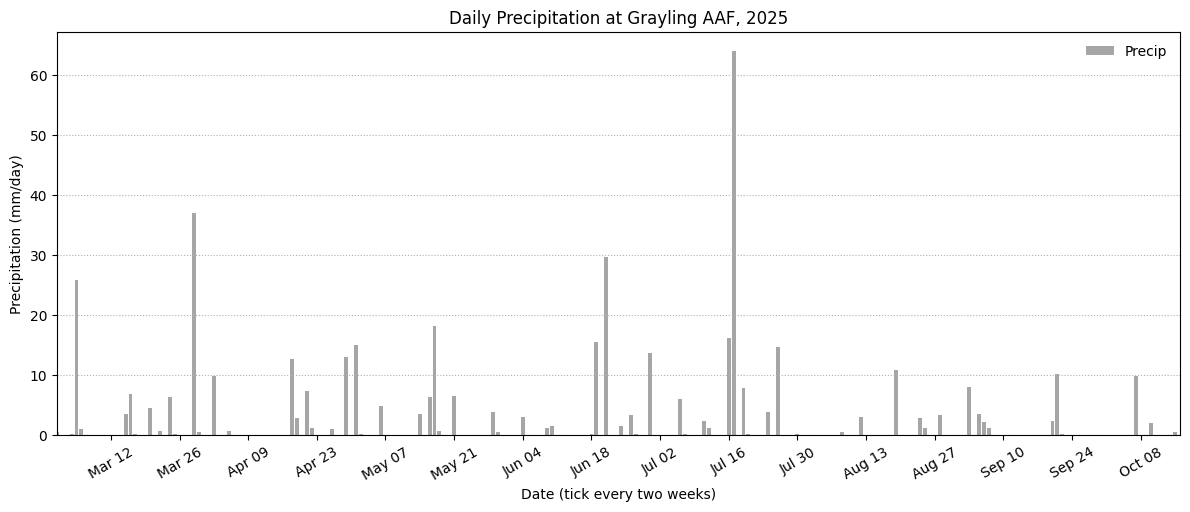

In [72]:
# Plot precipitation alone

# First set figure size/prepare canvas 
    #syntax: fig, ax = plt.subplots(figsize=(width, height)) where units is inches
fig, ax1 = plt.subplots(figsize=(12,5)) #make plot longer but not any taller

# First y-axis
ax1.bar(daily_rain_df.index, daily_rain_df['Daily Precip (mm)'], color="gray", alpha=0.7, label="Precip")
ax1.set_ylabel("Precipitation (mm/day)")
#ax1.set_ylim(80, 0) #removing allows for auto-adjust based on data range
ax1.tick_params(axis="y")
ax1.grid(axis='y', linestyle=':') #dotted grid lines

# Customize x-axis ticks
start_date = datetime(2025, 3, 1)
end_date = datetime(2025, 10, 16)
ax1.set_xlim(start_date, end_date)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14)) #sets ticks every 14 days
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) #formats labels as month day
ax1.tick_params(axis='x', rotation=30)
ax1.set_xlabel("Date (tick every two weeks)") #adds an axis label

ax1.legend(loc='upper right', frameon=False) 

# Plot the whole thing and add a title
fig.tight_layout() #adjusts spacing between subplots, labels, and titles so that nothing overlaps. recommend to use any time you have rotated dates, twin axes, multiple legends, etc.
plt.title("Daily Precipitation at Grayling AAF, 2025")
plt.show()

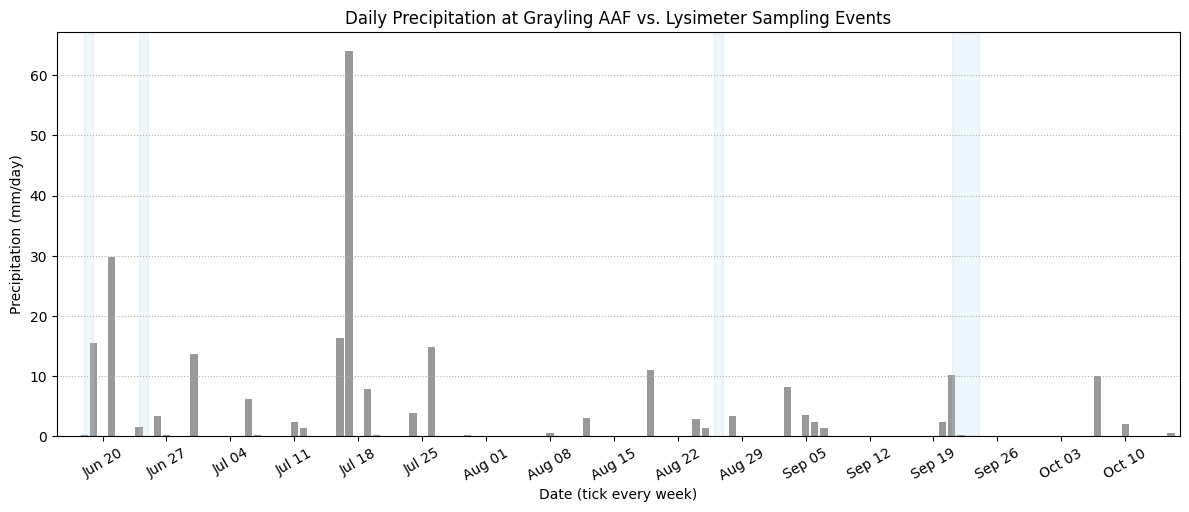

In [ ]:
# Precipitation over lysimeter sampling period
    #could remake this with a rolling average

fig, ax1 = plt.subplots(figsize=(12,5)) #make plot longer but not any taller

# First y-axis
ax1.bar(daily_rain_df.index, daily_rain_df['Daily Precip (mm)'], color="gray", alpha=0.8, label="Precip")
ax1.set_ylabel("Precipitation (mm/day)")
#ax1.set_ylim(80, 0) #removing allows for auto-adjust based on data range
ax1.tick_params(axis="y")
ax1.grid(axis='y', linestyle=':') #dotted grid lines

# Customize x-axis ticks
start_date = datetime(2025, 6, 15)
end_date = datetime(2025, 10, 16)
ax1.set_xlim(start_date, end_date)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) #formats labels as month day
ax1.tick_params(axis='x', rotation=30)
ax1.set_xlabel("Date (tick every week)")
#ax1.legend(loc='upper right', frameon=False) 

# Highlight a specific date range with semi-transparent colored bars
highlight_ranges = [ #populate with list of date ranges aka tuples
    #days samples were collected from the lysimeters, should adjust for dates the vacc was set
    (datetime(2025, 6, 18), datetime(2025, 6, 19)), 
    (datetime(2025, 6, 24), datetime(2025, 6, 25)),
    (datetime(2025, 8, 26), datetime(2025, 8, 27)),
    (datetime(2025, 9, 21), datetime(2025, 9, 24))] #when sampling event is over confirm dates
for start, end in highlight_ranges:
    ax1.axvspan(start, end, color='lightblue', alpha=0.2)  # alpha controls transparency, lower alpha is more transparent

# Plot the whole thing and add a title
fig.tight_layout() #adjusts spacing between subplots, labels, and titles so that nothing overlaps. recommend to use any time you have rotated dates, twin axes, multiple legends, etc.
plt.title("Daily Precipitation at Grayling AAF vs. Lysimeter Sampling Events")
plt.show()

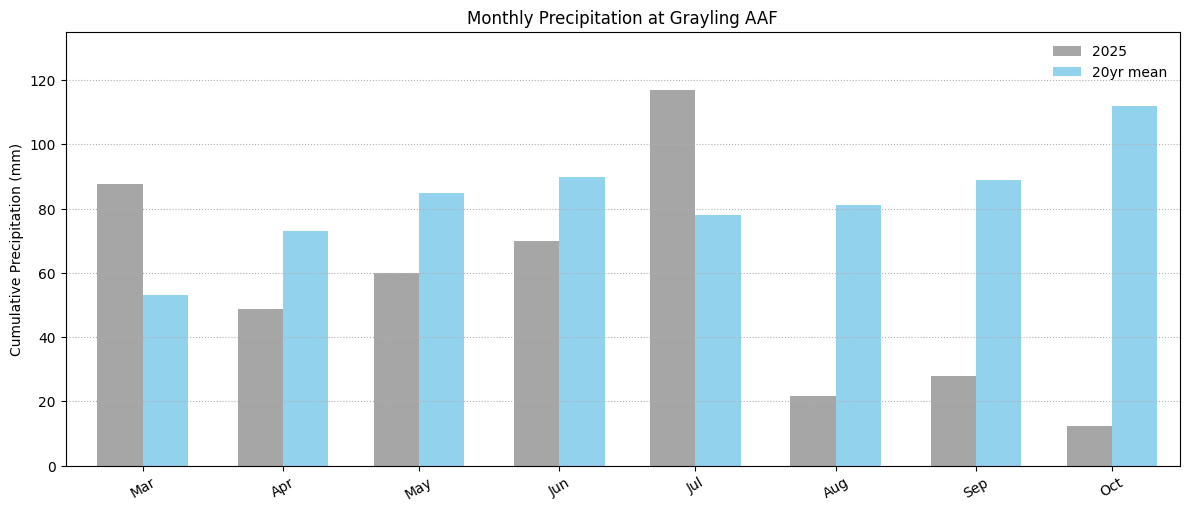

In [ ]:
# Compare monthly rainfall
    #misleading -- October data is for half the month (10/1 to 10/15) so this value will change
 
# Resample GAAF hourly rainfall to daily totals
monthly_rain_df = rain_df.resample("MS").sum() #monthly cumulative precip 
    #ME indicates setting date the the end of each month, same as M
    #MS indicates the beginning
monthly_rain_df = monthly_rain_df.rename(columns={"p01m": "Monthly Precip (mm)"}) #rename the column
monthly_rain_df.index.name = 'Month' #rename the index column
#monthly_rain_df.head()

# New dataframe of 20yr normals
    #data from nearby NWS station, units are inches. https://www.weather.gov/wrh/Climate?wfo=apx
    #site name KALKASKA, MI
    #source: Monthly tab in "GAAF Precipication June-July 2025_graph.mod (partial version uploaded 8.14)"
string = [5.2, 3.8, 5.3, 7.3, 8.5, 9.0, 7.8, 8.1, 8.9, 11.2, 7.2, 5.9] #units cm
precip_values = [val * 10 for val in string]  #convert to mm
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
dates = pd.to_datetime(['2025-' + m for m in months]) #set datetime index using 2025 as dummy year to make plotting easier
monthly_normals = pd.DataFrame({'Precipitation (mm)': precip_values}, #curly brackets vs. square make dataframe from dictionary therefore vertical list
                               index=dates) 
monthly_normals.index.name = 'Month'
#monthly_normals.head()

#Plot
fig, ax = plt.subplots(figsize=(12,5)) #make plot longer but not any taller

# Plot y-axis including offset of bars for visibility
x_rain = mdates.date2num(monthly_rain_df.index) #convert datetime index to matplotlib date numbers so can offset bars from x-axis labels
x_normals = mdates.date2num(monthly_normals.index) #do this for both datasets
ax.bar(x_rain - 5, monthly_rain_df['Monthly Precip (mm)'], width=10,  # width in days (must be numeric)
    color="gray", alpha=0.7, label="2025")
ax.bar(x_normals + 5, monthly_normals['Precipitation (mm)'], width=10, 
    color="skyblue", alpha=0.9, label="20yr mean")
ax.set_ylabel("Cumulative Precipitation (mm)")
ax.set_ylim(0, 135) #shrink a little to not block legend
ax.tick_params(axis="y")
ax.grid(axis='y', linestyle=':') #dotted grid lines

# Customize x-axis ticks, show only spring/summer season
start_date = datetime(2025, 2, 12) #start before actual data begins to show width of March bar
end_date = datetime(2025, 10, 16)
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) #use 3 letter month abbreviations
ax.tick_params(axis='x', rotation=30)
#ax.set_xlabel("Month") 

#for x_val, height in zip(x_normals + 5, monthly_rain_df['Monthly Precip (mm)']):
#    ax.text(x_val, height + 3, f"{height:.0f}", ha='center', va='bottom', fontsize=9, color='black')

ax.legend(loc='upper right', frameon=False) 

# Plot the whole thing and add a title
fig.tight_layout() #adjusts spacing between subplots, labels, and titles so that nothing overlaps. recommend to use any time you have rotated dates, twin axes, multiple legends, etc.
plt.title("Monthly Precipitation at Grayling AAF")
plt.show()

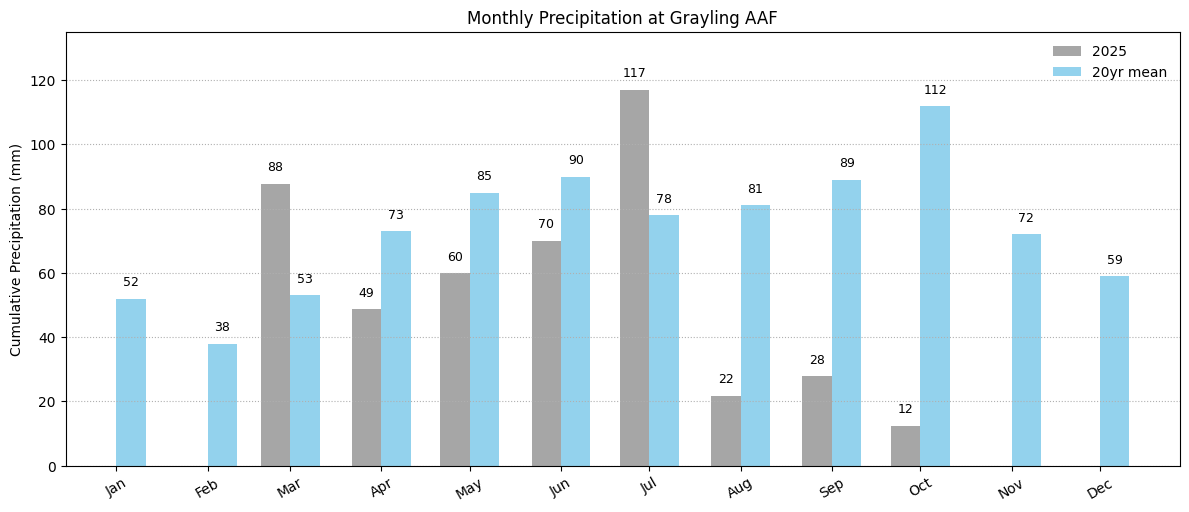

In [170]:
# Compare monthly rainfall for full year
 
#Plot
fig, ax = plt.subplots(figsize=(12,5)) #make plot longer but not any taller

# Plot y-axis including offset of bars for visibility
x_rain = mdates.date2num(monthly_rain_df.index) #convert datetime index to matplotlib date numbers so can offset bars from x-axis labels
x_normals = mdates.date2num(monthly_normals.index) #do this for both datasets
ax.bar(x_rain - 5, monthly_rain_df['Monthly Precip (mm)'], width=10,  # width in days (must be numeric)
    color="gray", alpha=0.7, label="2025")
ax.bar(x_normals + 5, monthly_normals['Precipitation (mm)'], width=10, 
    color="skyblue", alpha=0.9, label="20yr mean")
ax.set_ylabel("Cumulative Precipitation (mm)")
ax.set_ylim(0, 135) #shrink a little to not block legend
ax.tick_params(axis="y")
ax.grid(axis='y', linestyle=':') #dotted grid lines

# Customize x-axis ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) #use 3 letter month abbreviations
ax.tick_params(axis='x', rotation=30)
#ax.set_xlabel("Month") 

#add lables
for x_val, height in zip(x_rain - 5, monthly_rain_df['Monthly Precip (mm)']):
    ax.text(x_val, height + 3, f"{height:.0f}", ha='center', va='bottom', fontsize=9, color='black')

for x_val, height in zip(x_normals + 5, monthly_normals['Precipitation (mm)']):
    ax.text(x_val, height + 3, f"{height:.0f}", ha='center', va='bottom', fontsize=9, color='black')

ax.legend(loc='upper right', frameon=False) 

# Plot the whole thing and add a title
fig.tight_layout() #adjusts spacing between subplots, labels, and titles so that nothing overlaps. recommend to use any time you have rotated dates, twin axes, multiple legends, etc.
plt.title("Monthly Precipitation at Grayling AAF")
plt.show()